In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets


# prepare data
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data/',
                               train=False,
                               transform=transforms.ToTensor())

# print lenght
print(len(train_dataset))


# prepare loader
# Data Loader (Input Pipeline)
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

0it [00:00, ?it/s]

9920512it [00:01, 9143033.37it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 137579.56it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2271122.82it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 52622.80it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
60000


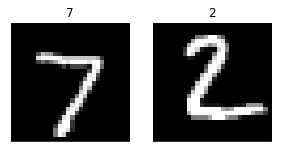

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# visualize data

data_iter = iter(test_loader)
images, labels = data_iter.next()

# show fig
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(2):
    ax = fig.add_subplot(1, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
  
  def __init__(self):
    super(Model, self).__init__()
    
    #cnn
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    #self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
  
    
    #max pooling layer
    self.mp = nn.MaxPool2d(2)
    
    # number of hidden nodes in each layer (512)
    hidden_1 = 512
    hidden_2 = 512
    # linear layer (784 -> hidden_1)
    self.fc1 = nn.Linear(320, hidden_1)
    # linear layer (n_hidden -> hidden_2)
    self.fc2 = nn.Linear(hidden_1, hidden_2)
    # linear layer (n_hidden -> 10)
    self.fc3 = nn.Linear(hidden_2, 10)
    # dropout layer (p=0.2)
    # dropout prevents overfitting of data
    self.dropout = nn.Dropout(0.2)
    
    
  def forward(self,x):
    inp = x.size(0) 
    #pass with cnn
    x = F.relu(self.mp(self.conv1(x)))
    x = F.relu(self.mp(self.conv2(x)))
    
    # resize tensor
    x = x.view(inp,-1) # 28*28
    # add hidden layer, with relu activation function
    x = F.relu(self.fc1(x))
    # add dropout layer
    x = self.dropout(x)
    # add hidden layer, with relu activation function
    x = F.relu(self.fc2(x))
    # add dropout layer
    x = self.dropout(x)
    # add output layer
    x = self.fc3(x)
    return x

In [19]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# Gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#move tensor to default device
model.to(device)

Model(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

In [20]:
n_epochs = 15

# compare overfited
train_loss_data,valid_loss_data = [],[]

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # Move input and label tensors to the default device
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() #*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in test_loader:
        # Move input and label tensors to the default device
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item() #*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(16):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1
        
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    
    #clculate train loss and running loss
    train_loss_data.append(train_loss)
    valid_loss_data.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    print('Test Accuracy: %4d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.033023 	Validation Loss: 0.006889
Test Accuracy:   93% (4701/5008)
Validation loss decreased (inf --> 0.006889).  Saving model ...
Epoch: 2 	Training Loss: 0.006173 	Validation Loss: 0.003602
Test Accuracy:   95% (9540/10016)
Validation loss decreased (0.006889 --> 0.003602).  Saving model ...
Epoch: 3 	Training Loss: 0.003817 	Validation Loss: 0.002375
Test Accuracy:   96% (14436/15024)
Validation loss decreased (0.003602 --> 0.002375).  Saving model ...
Epoch: 4 	Training Loss: 0.002874 	Validation Loss: 0.002144
Test Accuracy:   96% (19334/20032)
Validation loss decreased (0.002375 --> 0.002144).  Saving model ...
Epoch: 5 	Training Loss: 0.002406 	Validation Loss: 0.001671
Test Accuracy:   96% (24256/25040)
Validation loss decreased (0.002144 --> 0.001671).  Saving model ...
Epoch: 6 	Training Loss: 0.002092 	Validation Loss: 0.001472
Test Accuracy:   97% (29190/30048)
Validation loss decreased (0.001671 --> 0.001472).  Saving model ...
Epoch: 7 	Training

In [21]:
# load the saved model
model.load_state_dict(torch.load('model.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

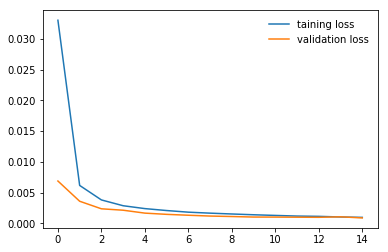

In [22]:
#My validation loss and training loss is not cross each other, so maybe I have to increase the epoch. Am I right?
# check for overfitting
plt.plot(train_loss_data, label = "taining loss")
plt.plot(valid_loss_data, label = "validation loss")
plt.legend(frameon = False)

In [23]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # Move input and label tensors to the default device
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(16):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.028561

Test Accuracy of     0: 99% (471/474)
Test Accuracy of     1: 99% (579/581)
Test Accuracy of     2: 99% (542/545)
Test Accuracy of     3: 99% (511/513)
Test Accuracy of     4: 99% (503/508)
Test Accuracy of     5: 98% (423/429)
Test Accuracy of     6: 99% (458/460)
Test Accuracy of     7: 98% (506/514)
Test Accuracy of     8: 98% (463/468)
Test Accuracy of     9: 98% (510/516)

Test Accuracy (Overall): 99% (4966/5008)


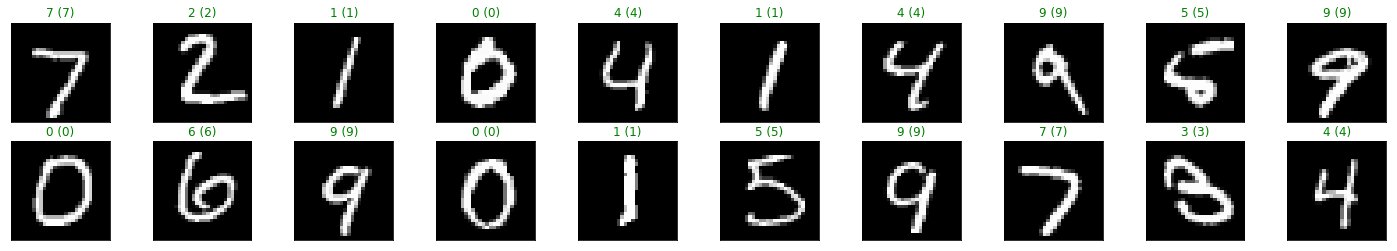

In [24]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# Move to cpu
model.cpu()
  
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))